# Some imports and helper code

In [342]:
import os
import pickle
import seaborn
import numpy as np
import pandas as pd
import scipy as sci
import networkx as nx
import numpy.linalg as LIN
import matplotlib.pylab as plt
np.random.seed(1)

%matplotlib inline 
%load_ext autoreload

plt.style.use('seaborn-paper')
seaborn.set_context('paper', font_scale=2.2)
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.weight'] = 'medium'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot_results(results, alphas):
    plt.figure()
    results[['lambda', 'lambda_sub', 'centrality']].plot(kind='line')
    plt.xlabel('iterations')
    title_template = r'$\alpha_1={:.2f}, \alpha_2={:.2f}, \alpha_3={:.2f}$'
    plt.title(title_template.format(*alphas))
    
    
def plot_adj_matrices(A, attacked_A):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(A, cmap='hot')
    axes[0].set_title('before attack')
    axes[1].imshow(attacked_A, cmap='hot')
    axes[1].set_title('after attack')

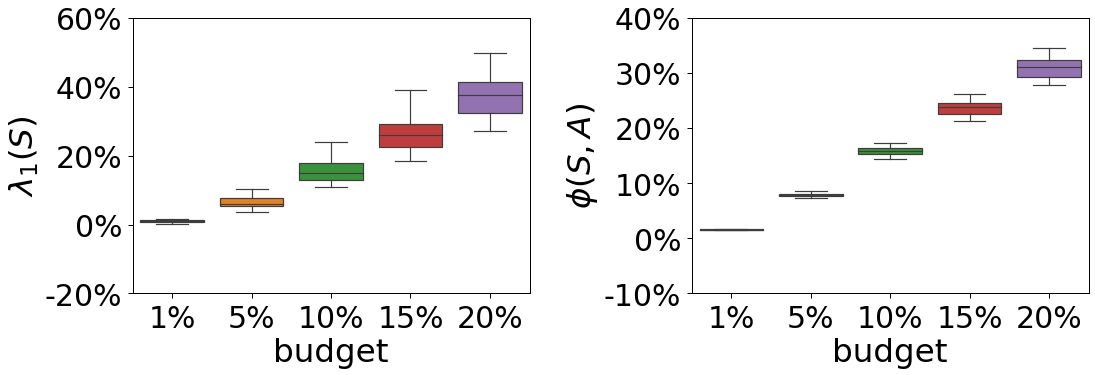

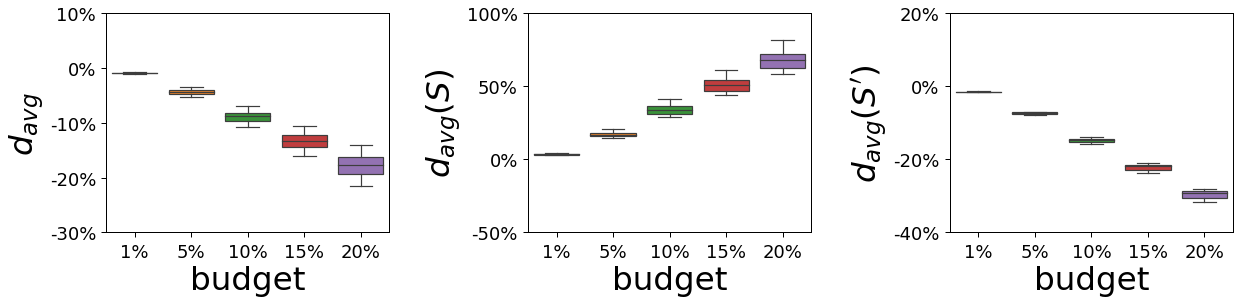

In [86]:
graph_type = 'BTER'
with open('../result/{}_numExp_15.p'.format(graph_type), 'rb') as fid:
    data = pickle.load(fid)

data_f = []
for budget in data.keys():
    for item in data[budget]:
        data_f.append([item[1], item[2], item[5], item[6], item[7], item[8], budget])
data_f = pd.DataFrame(data_f, columns=['lambda1_S', 'centrality', \
                                       'avgDegree', 'avgDegree_S', 'avgDegree_S_prime', 'avgNormDiff', 'budget'], dtype=np.float32)        
data_f = data_f.dropna()

seaborn.set_context('paper', font_scale=3.4)
f, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = seaborn.boxplot(x='budget', y='lambda1_S', data=data_f, orient='v', showfliers=False, ax=axes[0])
plt.sca(ax)
plt.xticks(range(5), ['1%', '5%', '10%', '15%', '20%'])
plt.yticks(ax.get_yticks(),  ['%.0f%%' % (i*100) for i in ax.get_yticks()])
plt.ylabel('$\lambda_1(S)$')
plt.xlabel('budget')
plt.tight_layout()

ax = seaborn.boxplot(x='budget', y='centrality', data=data_f, orient='v', showfliers=False, ax=axes[1])
plt.sca(ax)
plt.xticks(range(5), ['1%', '5%', '10%', '15%', '20%'])
plt.yticks(ax.get_yticks(),  ['%.0f%%' % (i*100) for i in ax.get_yticks()])
plt.ylabel('$\phi(S, A)$')
plt.tight_layout()
# plt.title("% of increases cut(S) - {}".format(graph_type))
# plt.savefig('../result/figure/{}_cut_numExp_15.pdf'.format(graph_type))



################################################################################

seaborn.set_context('paper', font_scale=3.4)
f, axes = plt.subplots(1, 3, figsize=(18, 5))
xtick_fontSize = 18
ytick_fontSize = 18


ax = seaborn.boxplot(x='budget', y='avgDegree', data=data_f, orient='v', showfliers=False, ax=axes[0])
plt.sca(ax)
plt.xticks(range(5), ['1%', '5%', '10%', '15%', '20%'], fontsize=xtick_fontSize)
plt.yticks(ax.get_yticks(),  ['%.0f%%' % (i*100) for i in ax.get_yticks()], fontsize=ytick_fontSize)
plt.ylabel('$d_{avg}$')
plt.xlabel('budget')
plt.tight_layout()

ax = seaborn.boxplot(x='budget', y='avgDegree_S', data=data_f, orient='v', showfliers=False, ax=axes[1])
plt.sca(ax)
plt.xticks(range(5), ['1%', '5%', '10%', '15%', '20%'], fontsize=xtick_fontSize)
plt.yticks(ax.get_yticks(),  ['%.0f%%' % (i*100) for i in ax.get_yticks()], fontsize=ytick_fontSize)
plt.ylabel('$d_{avg}(S)$')
plt.tight_layout()

ax = seaborn.boxplot(x='budget', y='avgDegree_S_prime', data=data_f, orient='v', showfliers=False, ax=axes[2])
plt.sca(ax)
plt.xticks(range(5), ['1%', '5%', '10%', '15%', '20%'], fontsize=xtick_fontSize)
plt.yticks(ax.get_yticks(),  ['%.0f%%' % (i*100) for i in ax.get_yticks()], fontsize=ytick_fontSize)
plt.ylabel('$d_{avg}(S\')$')
plt.tight_layout()
# plt.title("% of increases cut(S) - {}".format(graph_type))
# plt.savefig('../result/figure/{}_cut_numExp_15.pdf'.format(graph_type))

################################################################################

# seaborn.set_context('paper', font_scale=3.4)
# f, ax = plt.subplots(1, 1, figsize=(6, 5))
# xtick_fontSize = 18
# ytick_fontSize = 18

# ax = seaborn.boxplot(x='budget', y='avgNormDiff', data=data_f, orient='v', showfliers=False, ax=ax)
# plt.sca(ax)
# plt.xticks(range(5), ['1%', '5%', '10%', '15%', '20%'], fontsize=xtick_fontSize)
# plt.yticks(ax.get_yticks(),  ['%.0f%%' % (i*100) for i in ax.get_yticks()], fontsize=ytick_fontSize)
# plt.ylabel('$d_{avg}$')
# plt.xlabel('budget')
# plt.tight_layout()

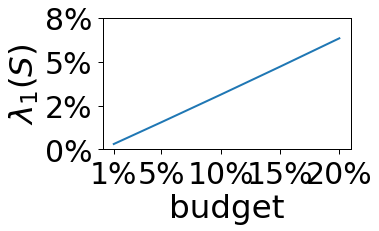

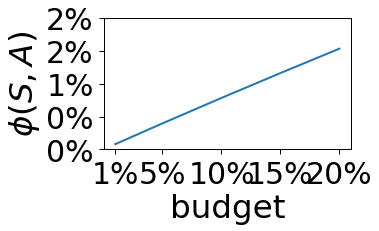

In [10]:
graph_type = 'Email'
cc = 50
with open('../result/{}_numExp_1_cc={}.p'.format(graph_type, cc), 'rb') as fid:
    data = pickle.load(fid)
    
data_f = []
for budget in data.keys():
    for item in data[budget]:
        data_f.append([item[1], item[2], budget])
data_f = pd.DataFrame(data_f, columns=['lambda1_S', 'centrality', 'budget'], dtype=np.float32)        
data_f = data_f.dropna()

plt.figure()
plt.plot(data_f['budget'], data_f['lambda1_S'], linewidth=2)
ax = plt.gca()
plt.xticks([0.01, 0.05, 0.1, 0.15, 0.2], ['1%', '5%', '10%', '15%', '20%'])
plt.yticks(ax.get_yticks(),  ['%.0f%%' % (i*100) for i in ax.get_yticks()])
plt.ylabel('$\lambda_1(S)$')
plt.xlabel('budget')
plt.tight_layout()
# plt.savefig('../result/figure/{}_lambda1S_cc={}.pdf'.format(graph_type, cc))

plt.figure()
plt.plot(data_f['budget'], data_f['centrality'],linewidth=2)
ax = plt.gca()
plt.xticks([0.01, 0.05, 0.1, 0.15, 0.2], ['1%', '5%', '10%', '15%', '20%'])
plt.yticks(ax.get_yticks(),  ['%.0f%%' % (i*100) for i in ax.get_yticks()])
plt.ylabel('$\phi(S, A)$')
plt.xlabel('budget')
plt.tight_layout()
# plt.savefig('../result/figure/{}_cut_cc={}.pdf'.format(graph_type, cc))

### Simulation results of epidemic spreading

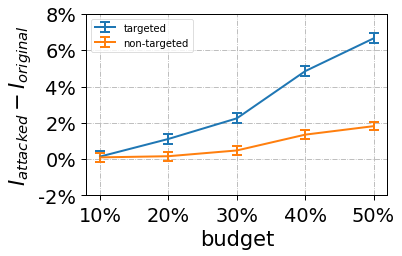

In [382]:
graph_type = 'Small-World'
numExp = 30
mode = 'min_eigcent_SP'
GAMMA = 0.24
TAU = 0.06


with open('../result/unweighted/{}/{}-SIS/Gamma-{:.2}---Tau-{:.2}/{}_numExp_{}_SIS_equalAlpha.p'.format(\
                                                mode, graph_type, GAMMA, TAU, graph_type, numExp), 'rb') as fid:
    data = pickle.load(fid)
data = data[~(data['ratio targets'].isin([0]) & data['ratio bystanders'].isin([0]))]
data = data.dropna()


SP_err = []
Key = 'ratio bystanders'
for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
    a = data[data['graph'].isin(['attacked']) & data['budget'].isin([budget])][Key] 
    a.index = range(len(a))
    b = data[data['graph'].isin(['original']) & data['budget'].isin([budget])][Key]
    b.index = range(len(b))
    SP_err.append((a-b).sem() * 1.96)
    
S_err = []
Key = 'ratio targets'
for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
    a = data[data['graph'].isin(['attacked']) & data['budget'].isin([budget])][Key] 
    a.index = range(len(a))
    b = data[data['graph'].isin(['original']) & data['budget'].isin([budget])][Key]
    b.index = range(len(b))
    S_err.append((a-b).sem() * 1.96)
    
    
S_attacked = data.pivot_table(index=['graph', 'budget'])['ratio targets']['attacked']
S_original = data.pivot_table(index=['graph', 'budget'])['ratio targets']['original']

SP_attacked = data.pivot_table(index=['graph', 'budget'])['ratio bystanders']['attacked']
SP_original = data.pivot_table(index=['graph', 'budget'])['ratio bystanders']['original']

S_diff  = S_attacked - S_original
SP_diff = SP_attacked - SP_original

x = [0.1, 0.2, 0.3, 0.4, 0.5]
plt.errorbar(x, S_diff, yerr=S_err, label='targeted', linewidth=2, markersize=7, capsize=5, elinewidth=2, markeredgewidth=2)
plt.errorbar(x, SP_diff, yerr=SP_err, label='non-targeted', linewidth=2, markersize=7, capsize=5, elinewidth=2, markeredgewidth=2)
plt.xticks(x, ['10%', '20%', '30%', '40%', '50%'])
ax = plt.gca()
plt.yticks(ax.get_yticks(),  ['%.0f%%' % (i*100) for i in ax.get_yticks()])
plt.xlabel('budget')
plt.ylabel('$I_{attacked} - I_{original}$')
plt.legend(fontsize=10, loc='upper left')
plt.grid(linestyle='-.')
plt.tight_layout()
# plt.savefig('../result/1.pdf'.format(graph_type, graph_type, numExp))

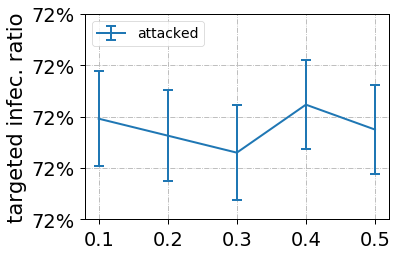

In [903]:
x = [0.1, 0.2, 0.3, 0.4, 0.5]
Key = 'ratio bystanders'
with open('../result/unweighted/min_lambda1_SP/{}-SIS/Gamma-0.24---Tau-0.06/{}_numExp_{}_SIS_alpha1=1.p'.format(graph_type, graph_type, numExp), 'rb') as fid:
    data = pickle.load(fid)

data = data[~(data['ratio targets'].isin([0]) & data['ratio bystanders'].isin([0]))]

S_attacked = data.pivot_table(index=['graph', 'budget'])[Key]['attacked']
S_original = data.pivot_table(index=['graph', 'budget'])[Key]['original']

Err_attacked = data.pivot_table(index=['graph', 'budget'], aggfunc='sem')[Key]['attacked'] * 1.96
# Err_original = data.pivot_table(index=['graph', 'budget'], aggfunc='sem')[Key]['original'] * 1.96

plt.errorbar(x, S_attacked, yerr=Err_attacked, label='attacked', linewidth=2, markersize=7, capsize=5, elinewidth=2, markeredgewidth=2)
# axs[idx].errorbar(x, S_original, yerr=Err_original, label='original', linewidth=2, markersize=7, capsize=5, elinewidth=2, markeredgewidth=2)
ax = plt.gca()
plt.yticks(ax.get_yticks(),  ['%.0f%%' % (i*100) for i in ax.get_yticks()])
plt.ylabel('targeted infec. ratio')
plt.legend(fontsize=14, loc='upper left')
plt.grid(linestyle='-.')
plt.tight_layout()
# plt.savefig('../result/{}-SIS/{}_numExp_{}_SIS_seedLoc.pdf'.format(graph_type, graph_type, numExp))

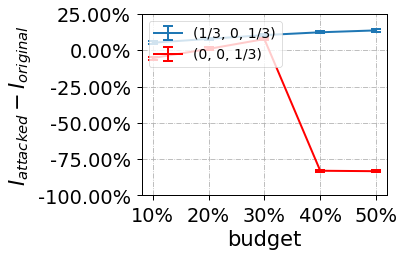

In [391]:
## Check if the normalized cut is really helpful in the long-run behavior

graph_type = 'Email'
numExp = 1
Key = 'ratio targets'
mode = 'min_eigcent_SP'
GAMMA = 0.24
TAU = 0.06


################################################################################################
## alpha_3 \ne 0
with open('../result/unweighted/{}/{}-SIS/Gamma-{:.2}---Tau-{:.2}/{}_numExp_{}_SIS_alpha2=0.p'.format(\
                                                mode, graph_type, GAMMA, TAU, graph_type, numExp), 'rb') as fid:
    data = pickle.load(fid)
data = data[~(data['ratio targets'].isin([0]) & data['ratio bystanders'].isin([0]))]
data = data.dropna()

S_err = []
for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
    a = data[data['graph'].isin(['attacked']) & data['budget'].isin([budget])][Key] 
    a.index = range(len(a))
    b = data[data['graph'].isin(['original']) & data['budget'].isin([budget])][Key]
    b.index = range(len(b))
    S_err.append((a-b).sem() * 1.96)
    
################################################################################################
## control experiments ##

with open('../result/unweighted/{}/{}-SIS/Gamma-{:.2}---Tau-{:.2}/{}_numExp_{}_SIS_alpha3=1.p'.format(\
                                                mode, graph_type, GAMMA, TAU, graph_type, numExp), 'rb') as fid:
    data_alpha3_zero = pickle.load(fid)
data_alpha3_zero = data_alpha3_zero[~(data_alpha3_zero['ratio targets'].isin([0]) & data_alpha3_zero['ratio bystanders'].isin([0]))]
data_alpha3_zero = data_alpha3_zero.dropna()
    
S_err_alpha3_zero = []
for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
    a = data_alpha3_zero[data_alpha3_zero['graph'].isin(['attacked']) & data_alpha3_zero['budget'].isin([budget])][Key] 
    a.index = range(len(a))
    b = data_alpha3_zero[data_alpha3_zero['graph'].isin(['original']) & data_alpha3_zero['budget'].isin([budget])][Key]
    b.index = range(len(b))
    S_err_alpha3_zero.append((a-b).sem() * 1.96)
    
################################################################################################

S_attacked = data.pivot_table(index=['graph', 'budget'])[Key]['attacked']
S_original = data.pivot_table(index=['graph', 'budget'])[Key]['original']
S_diff  = S_attacked - S_original

S_attacked_control = data_alpha3_zero.pivot_table(index=['graph', 'budget'])[Key]['attacked']
S_original_control = data_alpha3_zero.pivot_table(index=['graph', 'budget'])[Key]['original']
S_diff_control = S_attacked_control - S_original_control


x = [0.1, 0.2, 0.3, 0.4, 0.5]
plt.errorbar(x, S_diff, yerr=S_err, label='(1/3, 0, 1/3)', linewidth=2, markersize=7, 
             capsize=5, elinewidth=2, markeredgewidth=2)
plt.errorbar(x, S_diff_control, yerr=S_err_alpha3_zero, label='(0, 0, 1/3)', linewidth=2, markersize=7, \
             capsize=5, elinewidth=2, markeredgewidth=2, color='r')
plt.xticks(x, ['10%', '20%', '30%', '40%', '50%'])
ax = plt.gca()
plt.yticks(ax.get_yticks(),  ['%.2f%%' % (i*100) for i in ax.get_yticks()])
plt.xlabel('budget')
plt.ylabel('$I_{attacked} - I_{original}$')
plt.legend(fontsize=14, loc='upper left')
plt.grid(linestyle='-.')
plt.tight_layout()
# plt.savefig('../result/4.pdf'.format(graph_type, graph_type, numExp))

In [275]:
### the statisticas about the largest eigenvlaues of BTER networks ###
import seaborn
n = 375
ret = []
for i in range(30):
    G = nx.read_edgelist('../data/BTER_{:02d}.txt'.format(i), nodetype=int)
    adj = nx.adjacency_matrix(G).todense()
    lambda1 = LIN.eig(adj)[0].max()
    ret.append(np.real(lambda1))
print(np.min(ret))
print(np.max(ret))

14.415055658217216
16.57809155392885


In [324]:
### the density of S/S' as the attacker's budget increases ###

graph_type = 'BTER'
numExp = 30
mode = 'min_lambda1_SP'
folder = '../result/utility_max/{}'.format(mode)
Key = 'equalAlpha'
graph_name = ['original', 'attacked']

with open(os.path.join(folder, '{}_numExp_{}_attacked_graphs_{}.p'.format(graph_type, numExp, Key)), 'rb') as fid:
    data = pickle.load(fid)

ret = []
for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
    for gn in graph_name:
        for exp in range(numExp):
            G = data[budget][exp][gn]
            S = [i for i in range(G.order()) if G.nodes[i]['target']]
            G_S = G.subgraph(S)
            ret.append((nx.density(G_S), gn, budget))
ret = pd.DataFrame(ret, columns=['S-density', 'graph', 'budget'])
y = ret.groupby(['graph', 'budget']).mean()
print(y)

                 S-density
graph    budget           
attacked 0.1      0.140566
         0.2      0.191147
         0.3      0.236868
         0.4      0.284333
         0.5      0.330474
original 0.1      0.121895
         0.2      0.121895
         0.3      0.121895
         0.4      0.121895
         0.5      0.121895


In [325]:
### the largest eigenvalue of G as the attacker's budget increases ###

graph_type = 'BTER'
numExp = 30
mode = 'min_lambda1_SP'
folder = '../result/utility_max/{}'.format(mode)
Key = 'equalAlpha'
graph_name = ['original', 'attacked']

with open(os.path.join(folder, '{}_numExp_{}_attacked_graphs_{}.p'.format(graph_type, numExp, Key)), 'rb') as fid:
    data = pickle.load(fid)

ret = []
for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
    for gn in graph_name:
        for exp in range(numExp):
            G = data[budget][exp][gn]
            adj = nx.adjacency_matrix(G).todense()
            lambda1 = np.real(LIN.eig(adj)[0].max())
            
            S = [i for i in range(G.order()) if G.nodes[i]['target']]
            G_S = G.subgraph(S)
            adj_S = nx.adjacency_matrix(G_S).todense()
            lambda1_S = np.real(LIN.eig(adj_S)[0].max())
            
            SP = [i for i in range(G.order()) if not G.nodes[i]['target']]
            G_SP = G.subgraph(SP)
            adj_SP = nx.adjacency_matrix(G_SP).todense()
            lambda1_SP = np.real(LIN.eig(adj_SP)[0].max())
            
            ret.append((lambda1, lambda1_S, lambda1_SP, gn, budget))
ret = pd.DataFrame(ret, columns=['lambda1', 'lambda1_S', 'lambda1_SP', 'graph', 'budget'])
y = ret.groupby(['graph', 'budget']).mean()
print(y)

                   lambda1  lambda1_S  lambda1_SP
graph    budget                                  
attacked 0.1     15.403256   4.627960   14.719437
         0.2     15.486215   6.280367   14.719437
         0.3     15.601294   7.854169   14.712773
         0.4     15.774454   9.330684   14.706561
         0.5     15.985187  10.749418   14.641721
original 0.1     15.375907   3.774782   14.719437
         0.2     15.375907   3.774782   14.719437
         0.3     15.375907   3.774782   14.719437
         0.4     15.375907   3.774782   14.719437
         0.5     15.375907   3.774782   14.719437


In [326]:
### the cut (non-normalized) size as the attacker's budget increases ###

graph_type = 'BTER'
numExp = 30
mode = 'min_lambda1_SP'
folder = '../result/utility_max/{}'.format(mode)
Key = 'alpha3=1'
graph_name = ['original', 'attacked']

with open(os.path.join(folder, '{}_numExp_{}_attacked_graphs_{}.p'.format(graph_type, numExp, Key)), 'rb') as fid:
    data = pickle.load(fid)

ret = []
for budget in [0.1, 0.2, 0.3, 0.4, 0.5]:
    for gn in graph_name:
        for exp in range(numExp):
            G = data[budget][exp][gn]
            S = [i for i in range(G.order()) if G.nodes[i]['target']]
            ret.append((nx.cut_size(G, S), gn, budget))
ret = pd.DataFrame(ret, columns=['cut size', 'graph', 'budget'])
y = ret.groupby(['graph', 'budget']).mean()
print(y)

                   cut size
graph    budget            
attacked 0.1     189.233333
         0.2     190.100000
         0.3     255.033333
         0.4     278.433333
         0.5     239.733333
original 0.1     189.233333
         0.2     189.233333
         0.3     189.233333
         0.4     189.233333
         0.5     189.233333


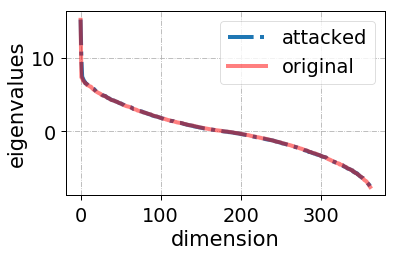

In [328]:
### the spectra before/after attack ###

graph_type = 'BTER'
numExp = 30
mode = 'min_lambda1_SP'
folder = '../result/utility_max/{}'.format(mode)
Key = 'equalAlpha'
graph_name = ['original', 'attacked']
budget = 0.5
exp = 10

with open(os.path.join(folder, '{}_numExp_{}_attacked_graphs_{}.p'.format(graph_type, numExp, Key)), 'rb') as fid:
    data = pickle.load(fid)
    
ret = {'attacked': None, 'original': None}
for key, _ in ret.items():
    G = data[budget][exp][key]
    adj = nx.adjacency_matrix(G).todense()
    eigVals = sorted(np.real(LIN.eig(adj)[0]), reverse=True)
    ret[key] = eigVals

x = range(len(G))
plt.plot(x, ret['attacked'], label='attacked', linestyle='-.', linewidth=4)
plt.plot(x, ret['original'], label='original', linewidth=4, alpha=0.5, color='r')
plt.legend()
plt.grid(linestyle='-.')
plt.ylabel('eigenvalues')
plt.xlabel('dimension')
plt.tight_layout()

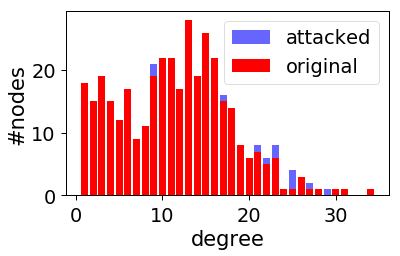

In [265]:
### the degree distributioin before/after attack ###
import collections

graph_type = 'BTER'
numExp = 30
mode = 'min_eigcent_SP'
folder = '../result/utility_max/{}'.format(mode)
Key = 'alpha1=1'
graph_name = ['attacked', 'original']
budget = 0.5
exp = 0

with open(os.path.join(folder, '{}_numExp_{}_attacked_graphs_{}.p'.format(graph_type, numExp, Key)), 'rb') as fid:
    data = pickle.load(fid)
    
plt.figure()
deg_dist = {'attacked': None, 'original': None}
for gn in graph_name:
    G = data[budget][exp][gn]
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    deg_dist[gn] = np.array(cnt) / np.sum(cnt)
    if gn == 'attacked':
        plt.bar(deg, cnt, width=0.8, color='b', alpha=0.6, label='attacked')
    else:
        plt.bar(deg, cnt, width=0.8, color='r', label='original')
plt.legend()
plt.ylabel('#nodes')
plt.xlabel('degree')
plt.tight_layout()